# Examples and exercises for causal models

In [24]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

# Only needed to generate graphs, may be safely ommitted 
# once you comment out relevant cells below
from graphviz import Digraph
from brent import DAG, Query

In [28]:
datadir = Path(os.getcwd()) / 'data'
datadir


WindowsPath('C:/Users/zankr/OneDrive/Dokumenti/GitHub/risk-ai-workshop/notebooks/data')

## Causal model example: hit rate

In [3]:
df = pd.read_csv(datadir / 'hits.csv')
print(df.shape)
df.head()

(5389, 4)


,product_type,days,rating,hit
0,property,3,1,0
1,liability,1,0,0
2,financial,0,1,0
3,liability,3,0,0
4,liability,0,0,1


In [4]:
dag = DAG(df).add_edge('product_type', 'rating').add_edge('product_type', 'days')\
    .add_edge('rating', 'hit').add_edge('days', 'hit')

dag.plot()

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

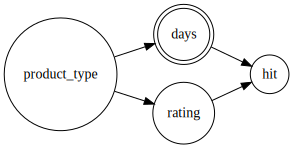

In [5]:
q_given = Query(dag).given(days=1)
dot = q_given.plot()
dot

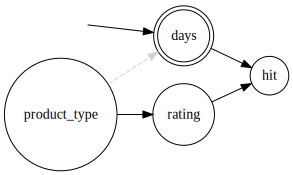

In [6]:
q_do = Query(dag).do(days=1)
dot = q_do.plot()
dot

In [7]:
# P(H=1 | D=d)
hit_given_d = df.groupby(['days'])
hit_given_d = hit_given_d['hit'].mean()
print('Probability of hit given days=d')
hit_given_d

Probability of hit given days=d


days
0    0.539135
1    0.440035
2    0.326531
3    0.168289
Name: hit, dtype: float64

In [8]:
# P(H=1 | do(D)=d) = \sum P(H=1 | D=d, P=p, R=r) * P(P=p, R=r)
# First term in sum
hit_given_prd = df.groupby(['product_type', 'rating', 'days'])
hit_given_prd = hit_given_prd['hit'].mean()
hit_given_prd

product_type  rating  days
financial     0       0       0.840659
                      1       0.687500
                      2       0.750000
                      3       0.666667
              1       0       0.305062
                      1       0.222222
                      2       0.111111
                      3       0.000000
liability     0       0       0.802139
                      1       0.584590
                      2       0.490411
                      3       0.404624
              1       0       0.287162
                      1       0.239865
                      2       0.059603
                      3       0.028571
property      0       0       0.842105
                      1       0.646154
                      2       0.571429
                      3       0.361111
              1       0       0.258065
                      1       0.182692
                      2       0.000000
                      3       0.013624
Name: hit, dtype: float64

In [9]:
# 2nd sum in P(H=1 | do(D)=1)
pr = df.groupby(['product_type', 'rating'])
p_pr = pr['hit'].count()
p_pr = p_pr / df.shape[0]
p_pr

product_type  rating
financial     0         0.039339
              1         0.158285
liability     0         0.349415
              1         0.150863
property      0         0.113565
              1         0.188532
Name: hit, dtype: float64

In [10]:
# Combine
hit_given_prd = hit_given_prd.reset_index()
p_pr = p_pr.reset_index()
res = pd.merge(hit_given_prd, p_pr, on=['product_type', 'rating'])
res['prob'] = res['hit_x'] * res['hit_y']
res = res.groupby('days')
res = res['prob'].sum()
print('Probability of hit do days=d:')
res

Probability of hit do days=d:


days
0    0.549247
1    0.410495
2    0.292335
3    0.215497
Name: prob, dtype: float64

## Causal models exercise: correlation

Reproduce and try to break the spurious correlation between deaths by poisonous spider bites and the lenghts of winning words in the Scripps national spelling bee.

The fatality data from the CDC can be found here: `notebooks/data/cdc-underlying-cause-of-death-1998-2018.txt`, and the spelling bee data can be found below.

Difficulty: **

In [21]:
# From https://en.wiktionary.org/wiki/Appendix:Scripps_winning_words
scripps_winners_raw = '''
    1925: gladiolus
    1926: abrogate
    1927: luxuriance
    1928: albumen
    1929: asceticism
    1930: fracas
    1931: foulard
    1932: knack
    1933: torsion
    1934: deteriorating
    1935: intelligible
    1936: interning
    1937: promiscuous
    1938: sanitarium
    1939: canonical
    1940: therapy
    1941: initials
    1942: sacrilegious

The Bee was suspended during the WWII years of 1943–1945.

    1946: semaphore
    1947: chlorophyll
    1948: psychiatry
    1949: dulcimer
    1950: meerschaum  / meticulosity
    1951: insouciant
    1952: vignette
    1953: soubrette
    1954: transept
    1955: crustaceology
    1956: condominium
    1957: n/a [2]
    1958: syllepsis
    1959: catamaran
    1960: eudaemonic
    1961: smaragdine
    1962: n/a [3]
    1963: equipage
    1964: sycophant
    1965: eczema
    1966: ratoon
    1967: chihuahua
    1968: abalone
    1969: interlocutory
    1970: croissant
    1971: shalloon
    1972: macerate

    1973: vouchsafe
    1974: hydrophyte
    1975: incisor
    1976: narcolepsy
    1977: cambist
    1978: deification
    1979: maculature
    1980: elucubrate
    1981: sarcophagus
    1982: psoriasis
    1983: Purim
    1984: luge
    1985: milieu
    1986: odontalgia
    1987: staphylococci
    1988: elegiacal
    1989: spoliator
    1990: fibranne
    1991: antipyretic
    1992: lyceum
    1993: kamikaze
    1994: antediluvian
    1995: xanthosis
    1996: vivisepulture
    1997: euonym
    1998: chiaroscurist
    1999: logorrhea
    2000: demarche
    2001: succedaneum
    2002: prospicience
    2003: pococurante
    2004: autochthonous
    2005: appoggiatura
    2006: Ursprache
    2007: serrefine
    2008: guerdon
    2009: Laodicean
    2010: stromuhr
    2011: cymotrichous
    2012: guetapens
    2013: knaidel
    2014: stichomythia / feuilleton
    2015: scherenschnitte / nunatak
    2016: Feldenkrais / gesellschaft
    2017: marocain
    2018: koinonia
    2019: auslaut / erysipelas / bougainvillea [4] / aiguillette / pendeloque / palama / cernuous / odylic
'''

In [55]:
list1 = scripps_winners_raw.split("\n")
list1 = [elem for elem in list1 if elem != '']
list1 = [elem.replace(' ', '') for elem in list1]
list1.remove('TheBeewassuspendedduringtheWWIIyearsof1943–1945.')
list1 = [elem.split(":") for elem in list1]
for elem in list1:
    list2 = elem[1].split('/')
    alt = list2[0]
    elem[1] = alt
words = pd.DataFrame(list1, columns=["Year", "Word"])
words["Year"] = words["Year"].apply(lambda x: int(x))
words["Word"] = words["Word"].apply(lambda x: len(x))
deaths = pd.read_csv(datadir / 'cdc-underlying-cause-of-death-1998-2018.txt', sep='\t')  
deaths["Cause of death"].unique()
spiders = deaths[deaths["Cause of death"] == 'Contact with venomous spiders'][["Year","Deaths"]]
spiders["Year"] = spiders["Year"].apply(lambda x: int(x))
spiders["Deaths"] = spiders["Deaths"].apply(lambda x: int(x))
new = pd.merge(spiders, words)
new[["Deaths", "Word"]].corr()
new.plot(y=["Deaths", "Word"],x="Year" )


,Deaths,Word
Deaths,1.000000,0.378804
Word,0.378804,1.000000


## Causal models exercise: do-calculus

As before, take K to be your Karma, H to be the hours you spend in the gym lifting weight, and then W be the weight you can bench press. 

You are the parent of a very young child, so Karma will punish you for devoting too much time to your triceps and neglecting your partner and baby. Let $G$ be this causal graph, as shown below.

In [5]:
dot = Digraph(engine='neato')
dot.attr('node')
dot.node('K')
dot.node('H')
dot.node('W')

dot.edge('K', 'H')
dot.edge('K', 'W')
dot.edge('H', 'W')

dot

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

1. Draw the graphs $G_\underline{W}$ and $G_\overline{H}$. Difficulty: *
2. Write out formulas for $P(W=1 | H=1)$ and $P(W=1|\, \mathrm{do}(H) = 1)$. Difficulty: **

3. Calculate $P(W=1 | H=1)$ and $P(W=1|\, \mathrm{do}(H) = 1)$ for a Bayesian network fitted to the sample data from $(K, H, W)$ in `notebooks/data/karma_weights.csv`. Hint: the `Query` class of [https://koaning.github.io/brent/](https://koaning.github.io/brent/) can be used. Interpret the results in a qualitative way, i.e. how do you think Karma should work in this situation? Difficulty: **

## Causal models exercise: Causal calculus

Prove in gory detail that the special case of Causal rule 3 holds. Difficulty: *